# 多 Agent 协作自动修复 K8s 故障

1. 管理员 Agent
2. 自动修复 Agent
3. 寻求人类帮助 Agent
4. 网络搜索 Agent
5. 执行代码 Agent

In [12]:
%%capture --no-stderr
%pip install -U langgraph langchain langchain_openai langchain_experimental langsmith pandas kubernetes openai

11409.65s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [13]:
# 导入环境变量
import getpass
import os

# 定义函数，设置未定义的环境变量
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

# 设置 OPENAI API 密钥
_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

import time
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool

# 初始化两个工具
tavily_tool = TavilySearchResults(max_results=5)
# 执行 Python 代码的工具，谨慎使用
python_repl_tool = PythonREPLTool()


In [14]:
# 定义消息 Agent 的节点
from langchain_core.messages import HumanMessage

# 定义一个消息代理节点，把结果封装成 HumanMessage 类型
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }

In [15]:
# 定义 supervisor Agent 和调度逻辑
# 管理员 Agent，负责决定下一个由哪个 Agent 来执行任务

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal,Sequence
import operator
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

# 定义成员 Agent 和系统提示语，告诉 supervisor 要负责调度多个 Agent
members = ["Researcher","Coder","GetK8sYAML","AutoFixK8s","HumanHelp"]
directmembers = ["Researcher","Coder","GetK8sYAML","HumanHelp"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
options = ["FINISH"] + members

# 定义 supervisor 的响应类，选择下一个执行的 Agent
class routeResponse(BaseModel):
    next: Literal[*options]

# 创建提示语模板
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            "Or should we FINISH Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(directmembers))

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str

# 定义 LLM 模型和 supervisor_agent 函数
llm = ChatOpenAI(model="gpt-4o",openai_api_base = "https://api.apiyi.com/v1")

def supervisor_agent(state):
    supervisor_chain = prompt | llm.with_structured_output(routeResponse)
    return supervisor_chain.invoke(state)

In [16]:
# 定义 K8s 自动修复工具
# 这里定义一个 K8s 自动修复工具，使用 OPENAI 模型生成 patch json
from langchain_core.tools import tool
from openai import OpenAI
from kubernetes import client, config, watch
import yaml

config.load_kube_config()
k8s_apps_v1 = client.AppsV1Api()
deployment_yaml = """
"""

@tool
def get_k8s_yaml (deployment_name, namespace):
    """获取 YAML 的功能"""
    global deployment_yaml
    deployment = k8s_apps_v1.read_namespaced_deployment(
        name=deployment_name, namespace=namespace
    )
    deployment_dict = deployment.to_dict()
    # 移除不必要的字段
    deployment_dict.pop("status", None)
    if "metadata" in deployment_dict:
        deployment_dict["metadata"].pop("managed_fields", None)
    
    # 请求 OpenAI 生成修复的 Patch JSON
    deployment_yaml = yaml.dump(deployment_dict)
    return f"获取 YAML 成功！"

@tool
def auto_fix_k8s(deployment_name, namespace, event: str):
    """自动修复 K8s 问题"""
    global deployment_yaml
    OpenAIClient = OpenAI(
        base_url="https://api.apiyi.com/v1",
    )
    response = OpenAIClient.chat.completions.create(
        model="gpt-4o",
        response_format={"type":"json_object"},
        messages=[
            {
                "role": "system",
                "content": "你是一个助理用来输出 JSON"
            },
            {
                "role": "user",
                "content": f"""你现在是一个云原生技术专家，现在你需要根据 K8s 的报错生成一个能通过 kubectl patch 的一段 JSON 内容来修复问题。
        K8s 抛出的错误信息是：{event}
        工作负载的 YAML 是：
        {deployment_yaml}
    你生成的 patch JSON 应该可以直接通过 kubectl patch 命令使用，除此之外不要提供其他无用的建议，直接返回 JSON，且不要把 JSON 放在代码块内
    """,
            }
        ]
    )

    json_opt = response.choices[0].message.content
    print(json_opt)

    # Apply Patch JSON
    try:
        k8s_apps_v1.patch_namespaced_deployment(
            name=deployment_name,
            namespace=namespace,
            body=yaml.safe_load(json_opt)
        )
    except Exception as e:
        print(f"修复失败：{str(e)}")
        return f"修复失败：{str(e)}"

    return f"工作自动修复成功！"

In [17]:
# 定义人工帮助的 Tool
# 用于在无法自动修复的时候发送飞书消息通知

import requests
import json

@tool
def human_help(event_message: str):
    """无法修复问题时寻求人工帮助"""
    url = "https://open.feishu.cn/open-apis/bot/v2/hook/d5e267dc-a92f-43d3-bc45-106b5e718c49"
    headers = {"Content-Type": "application/json"}
    data = {"msg_type": "text", "content": {"text": event_message}}
    response = requests.post(url, headers=headers, data=json.dumps(data))
    return "寻求人类帮助成功，结束任务"

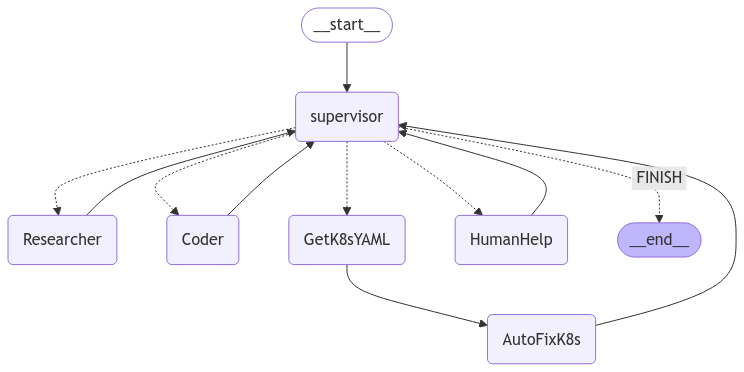

In [18]:
# 定义工作流和 Graph（有向有环图）
# 创建工作流，并且给节点添加 route 路由逻辑

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent
import functools

# 创建 research agent
research_agent = create_react_agent(llm, tools=[tavily_tool])
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# code agent
code_agent = create_react_agent(llm, tools=[python_repl_tool])
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

# get k8s yaml
get_yaml_agent = create_react_agent(llm, tools=[get_k8s_yaml])
get_yaml_node = functools.partial(agent_node, agent=get_yaml_agent, name="GetK8sYAML")

# auto fix agent
auto_fix_agent = create_react_agent(llm, tools=[auto_fix_k8s])
auto_fix_node = functools.partial(agent_node, agent=auto_fix_agent, name="AutoFixK8s")

# human help agent
human_help_agent = create_react_agent(llm, tools=[human_help])
human_help_node = functools.partial(agent_node, agent=human_help_agent, name="HumanHelp")

# 创建 Graph 并且添加节点
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor", supervisor_agent)
workflow.add_node("GetK8sYAML", get_yaml_node)
workflow.add_node("AutoFixK8s", auto_fix_node)
workflow.add_node("HumanHelp", human_help_node)

# 定义路由逻辑
for member in members:
    if member == "GetK8sYAML":
        workflow.add_edge("GetK8sYAML", "AutoFixK8s")
    else:
        workflow.add_edge(member, "supervisor")


conditional_map = {k:k for k in directmembers}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)


workflow.add_edge("GetK8sYAML", "AutoFixK8s")
workflow.add_edge(START, "supervisor")

# 编译 Graph
graph = workflow.compile()

# 展示 Graph
from IPython.display import display, Image
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    pass






In [22]:
# 硬编码 Event 测试效果
# kubectl create deployment nginx --image=nginx:latess --port=80
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="deployment: nginx, namespace: default, event: Back-off pulling image 'nginx:latess'")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'GetK8sYAML'}}
----
{'GetK8sYAML': {'messages': [HumanMessage(content='It seems that you\'re encountering an issue with the deployment of Nginx in the default namespace, specifically a "Back-off pulling image \'nginx:latess\'" error. This error typically occurs when Kubernetes is unable to pull the specified image from the container registry, which may be due to a typo in the image name or tag.\n\nHere is the current configuration for your Nginx deployment:\n\n```yaml\napiVersion: apps/v1\nkind: Deployment\nmetadata:\n  name: nginx\n  namespace: default\nspec:\n  replicas: 1\n  selector:\n    matchLabels:\n      app: nginx\n  template:\n    metadata:\n      labels:\n        app: nginx\n    spec:\n      containers:\n      - name: nginx\n        image: nginx:latess  # <-- This is likely the source of the error\n        ports:\n        - containerPort: 80\n```\n\n### Solution\n1. **Check the Image Name:** Ensure that the image name and tag are correct. The official